In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from xgboost import plot_importance
from skopt import BayesSearchCV

In [2]:
TESS = pd.read_csv("TESS.csv", skiprows=69)

# Cleaning

In [4]:
TESS.head()

,toi,tid,tfopwg_disp,rastr,ra,decstr,dec,st_pmra,st_pmraerr1,st_pmraerr2,...,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_rad,st_raderr1,st_raderr2,st_radlim,toi_created,rowupdate
0,1000.01,50365310,FP,07h29m25.85s,112.357708,-12d41m45.46s,-12.695960,-5.964,0.085,-0.085,...,4.19,0.07,-0.07,0,2.16986,0.072573,-0.072573,0,2019-07-24 15:58:33,2024-09-09 10:08:01
1,1001.01,88863718,PC,08h10m19.31s,122.580465,-05d30m49.87s,-5.513852,-4.956,0.102,-0.102,...,4.03,0.09,-0.09,0,2.01000,0.090000,-0.090000,0,2019-07-24 15:58:33,2023-04-03 14:31:04
2,1002.01,124709665,FP,06h58m54.47s,104.726966,-10d34m49.64s,-10.580455,-1.462,0.206,-0.206,...,NaN,NaN,NaN,0,5.73000,NaN,NaN,0,2019-07-24 15:58:33,2022-07-11 16:02:02
3,1003.01,106997505,FP,07h22m14.39s,110.559945,-25d12m25.26s,-25.207017,-0.939,0.041,-0.041,...,4.15,1.64,-1.64,0,NaN,NaN,NaN,0,2019-07-24 15:58:33,2022-02-23 10:10:02
4,1004.01,238597883,FP,08h08m42.77s,122.178195,-48d48m10.12s,-48.802811,-4.496,0.069,-0.069,...,4.14,0.07,-0.07,0,2.15000,0.060000,-0.060000,0,2019-07-24 15:58:33,2024-09-09 10:08:01


### Labels 

In [6]:
TESS = TESS[(TESS["tfopwg_disp"] != "FA") & (TESS["tfopwg_disp"] != "APC")]
TESS.loc[TESS["tfopwg_disp"] == "KP", "tfopwg_disp"] = "CP"

### Drop & Rename Columns

In [8]:
drop_cols = ["toi", "tid", "toi_created", "rowupdate", "rastr", "decstr"]
TESS.drop(drop_cols, axis=1, inplace=True)

In [9]:
TESS.rename({"tfopwg_disp":"Labels"}, axis=1, inplace=True)

### Drop Empty Rows

In [11]:
TESS.dropna(how="all", inplace=True)

### Drop Columns with too many NaNs

In [13]:
n_nans = 7000
which_nan = []

for col in TESS.columns.to_list():
    n = TESS[col].isnull().sum().sum()
    if n > n_nans:
        which_nan.append(col)
print(which_nan)   

['pl_insolerr1', 'pl_insolerr2', 'pl_insollim', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim']


In [14]:
TESS.drop(which_nan, axis=1, inplace=True)

### Drop Duplicate Rows

In [16]:
TESS.drop_duplicates(inplace=True, keep="first")

### Drop Columns with the same value for every row

In [18]:
which_0 = []

for col in TESS.columns:
    if TESS[col].nunique() == 1:
        which_0.append(col)
print(which_0)

['st_pmralim', 'st_pmdeclim', 'pl_tranmidlim', 'pl_orbperlim', 'pl_trandurhlim', 'pl_trandeplim', 'pl_radelim', 'st_tmaglim', 'st_distlim', 'st_tefflim', 'st_logglim', 'st_radlim']


In [19]:
TESS.drop(which_0, axis=1, inplace=True)

### Drop Perfectly Correlated Error Columns

In [21]:
problem_cols = []
for col in TESS.columns:
    if "err1" in col:
        partner_col = col.replace("1", "2")
        problem_cols.append([col, partner_col])
print(problem_cols)

[['st_pmraerr1', 'st_pmraerr2'], ['st_pmdecerr1', 'st_pmdecerr2'], ['pl_tranmiderr1', 'pl_tranmiderr2'], ['pl_orbpererr1', 'pl_orbpererr2'], ['pl_trandurherr1', 'pl_trandurherr2'], ['pl_trandeperr1', 'pl_trandeperr2'], ['pl_radeerr1', 'pl_radeerr2'], ['st_tmagerr1', 'st_tmagerr2'], ['st_disterr1', 'st_disterr2'], ['st_tefferr1', 'st_tefferr2'], ['st_loggerr1', 'st_loggerr2'], ['st_raderr1', 'st_raderr2']]


In [22]:
for pair in problem_cols:
    if (TESS[pair[0]].dropna() == -TESS[pair[1]].dropna()).all():
        TESS.drop(pair[1], axis=1, inplace=True)

# TDA

In this section we apply a novel feature engineering technique which has been used in Neurobiology for the last two decades but has not been implemented in Space-related research so far. It based on advanced pure mathematics. In particular, it is based on Topology. It basically captures signals that classical techniques cannot, known as Topological Invariants.

In [25]:
# Step 0: Keep labels aside and store original data
labels = TESS["Labels"].copy()
TESS_numeric = TESS.drop("Labels", axis=1).copy()  # numeric features, may contain NaNs

# Step 1: Imports
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer

# giotto-tda
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, BettiCurve

# Step 2: Temporary KNN imputation for TDA computation
imputer = KNNImputer(n_neighbors=5)  # can tune neighbors
X_imputed = imputer.fit_transform(TESS_numeric.values)

# Step 3: Scale the imputed data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Step 4: Build nearest neighbor search
k = 30
nn = NearestNeighbors(n_neighbors=k, metric="euclidean")
nn.fit(X_scaled)

# Step 5: Extract neighborhoods as point clouds
neighborhoods = []
for i in range(X_scaled.shape[0]):
    distances, indices = nn.kneighbors(X_scaled[i].reshape(1, -1))
    local_cloud = X_scaled[indices[0]]  # (k, n_features)
    neighborhoods.append(local_cloud)

neighborhoods = np.array(neighborhoods)  # shape (n_samples, k, n_features)


# Step 6: Compute persistence diagrams
VR = VietorisRipsPersistence(homology_dimensions=[0, 1], metric="euclidean")
diagrams = VR.fit_transform(neighborhoods)

# Step 7a: Persistence Entropy
PE = PersistenceEntropy()
entropy_features = PE.fit_transform(diagrams)

# Step 7b: Total Persistence
def total_persistence(diagrams):
    totals = []
    for diag in diagrams:
        row = []
        for dim in [0, 1]:
            mask = diag[:, 2] == dim
            lifetimes = diag[mask, 1] - diag[mask, 0]
            row.append(lifetimes.sum())
        totals.append(row)
    return np.array(totals)

total_features = total_persistence(diagrams)

# Step 8: Combine all TDA features
tda_features_combined = np.hstack([entropy_features, total_features])
tda_feature_names = (
    [f"tda_entropy_dim{i}" for i in range(entropy_features.shape[1])] +
    [f"tda_total_dim{i}" for i in range(total_features.shape[1])]
)
tda_df = pd.DataFrame(tda_features_combined, columns=tda_feature_names)

# Step 9: Concatenate TDA features with original dataset (including NaNs)
TESS = pd.concat([labels.reset_index(drop=True), TESS_numeric.reset_index(drop=True), tda_df.reset_index(drop=True)], axis=1)

# Cross-Validation

In [27]:
# Separate features (x) and labels (y)
x = TESS.drop("Labels", axis=1) # only features
y = TESS["Labels"] # only label

In [28]:
# Encode the labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [29]:
# Split in train and test data
x_train, x_test, y_train, y_test = train_test_split( x, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42 )

In [30]:
# Make the model:
xgb = XGBClassifier(objective="multi:softmax",num_class=len(le.classes_), eval_metric="mlogloss", random_state=42)

# Define the range of search (ranges, no lists)
search_spaces = {
    "n_estimators": (100, 1200),      
    "learning_rate": (0.001, 1, "log-uniform"),
    "max_depth": (3, 15),
    "subsample": (0.3, 1.0, "uniform"),
    "colsample_bytree": (0.3, 1.0, "uniform")
}

# Search optimal parameters for the model and do cross validation
bayes = BayesSearchCV(
    estimator=xgb,
    search_spaces=search_spaces,
    n_iter=50,   
    cv=3,
    n_jobs=-1,
    scoring="recall_macro",
    verbose=1,
    random_state=42
)
# Fit the model
bayes.fit(x_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='mlogloss',
                                      feature_types=None, feature_weights=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constrai...
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_class=3, ...),
              n_jobs=-1, random_state=42, scoring='recall_macro',
              search_spaces={'colsample_bytree': (0.3, 1.0, 'uniform'),
                             'learning_rate': (0.001, 1, 'log-uniform'),
                             'max_depth': (3, 15), 'n_estimators': (100, 1200),
                             'subsample': (0.3, 1.0, 'uniform')},
              verbose=1)

In [31]:
print("Best parameters:", bayes.best_params_)
print("Best score:", bayes.best_score_)

Best parameters: OrderedDict({'colsample_bytree': 1.0, 'learning_rate': 1.0, 'max_depth': 3, 'n_estimators': 1200, 'subsample': 1.0})
Best score: 0.6543330878960093


In [32]:
# After the search we have the best model:
best_model = bayes.best_estimator_

#Predictions, test and scoring 
y_pred = best_model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7886634009797061
Classification report:
               precision    recall  f1-score   support

          CP       0.70      0.62      0.66       254
          FP       0.70      0.58      0.64       239
          PC       0.83      0.89      0.85       936

    accuracy                           0.79      1429
   macro avg       0.74      0.70      0.72      1429
weighted avg       0.78      0.79      0.78      1429

Confusion matrix:
 [[158  10  86]
 [ 10 139  90]
 [ 57  49 830]]


<Figure size 1000x600 with 0 Axes>

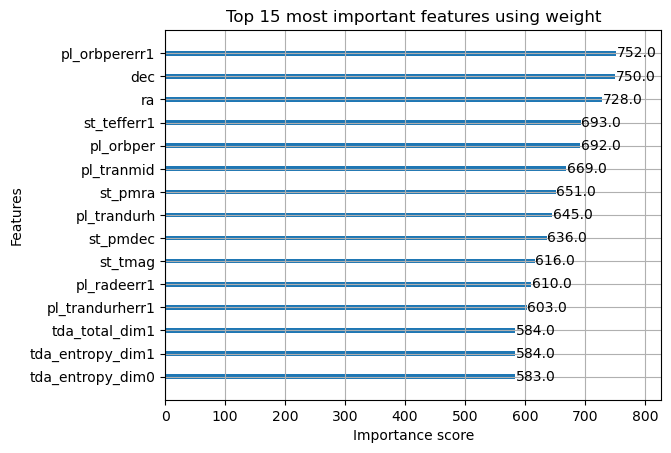

In [33]:
# Top 15 most important features using weight
plt.figure(figsize=(10,6))
plot_importance(best_model, max_num_features=15)
plt.title("Top 15 most important features using weight")
plt.show()

<Figure size 1000x600 with 0 Axes>

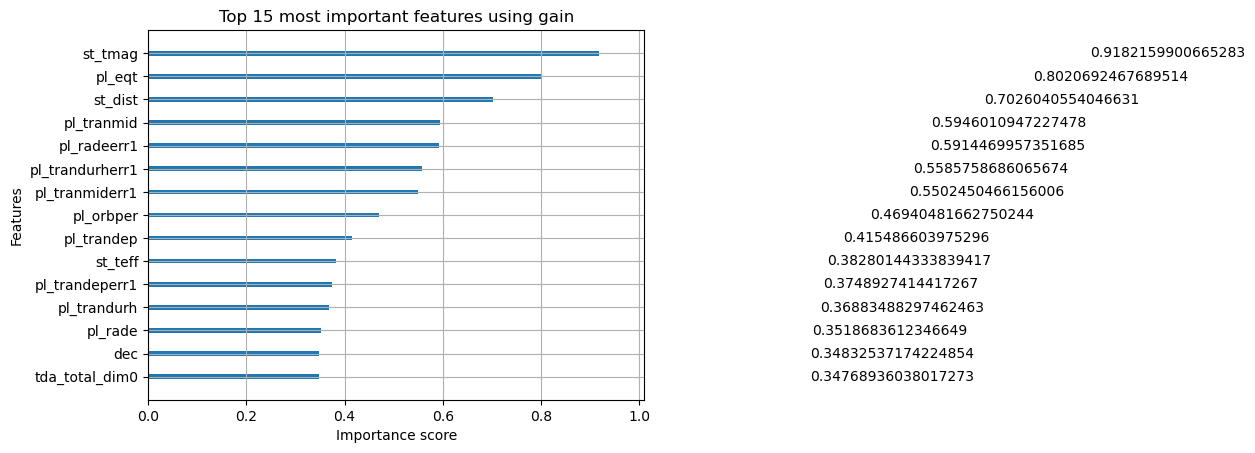

In [34]:
# Top 15 most important features using gain
plt.figure(figsize=(10,6))
plot_importance(best_model, max_num_features=15,importance_type="gain")
plt.title("Top 15 most important features using gain")
plt.show()

### Save the Model

In [36]:
import joblib

In [37]:
joblib.dump(best_model, "tess_model.pkl")

['tess_model.pkl']